# Training an RNN on the Adding Problem

In this notebook we will train a simple Recurrent Neural Network on the adding problem. 
The adding problem is a typical task to benchmark RNNs, that consists in adding exactly two numbers (determined by a binary mask) between a sequence of random numbers in $[0, 1]$. 

This tasks can let us evaluate if the network has correctly learned time dependencies.

First, we load the necessary packages.


As a model choice, we will use a Long Short Term Memory (LSTM)

In [1]:
import sys
sys.path.append("..")
import torch
from torch.utils.data import Dataset, DataLoader
import jax
import numpy as np
import equinox as eqx # pytree utilities
import optax # optimizers
from einops import rearrange 
from cells import LongShortTermMemory
from layers import RNN
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt

In [2]:
key = jax.random.key(0)
in_key, out_key, key = jax.random.split(key, 3)
model = RNN(cell=LongShortTermMemory(2, 64, key=in_key), odim=1, key=out_key)

First, we make a simple utility function to make the adding problem dataset

In [3]:
BATCH_SIZE = 128

def make_adding_problem(n_samples=10_000, seq_len=100, key=key):
    import jax.random as jr
    import jax.numpy as jnp
    key1, key2, key3 = jr.split(key, 3)
    x = jr.uniform(key1, (n_samples, seq_len, 1))
    mask = jnp.zeros((n_samples, seq_len, 1))
    idx1 = jr.randint(key2, (n_samples,), 0, seq_len)
    idx2 = jr.randint(key3, (n_samples,), 0, seq_len - 1)
    idx2 = jnp.where(idx2 >= idx1, idx2 + 1, idx2)
    mask = mask.at[jnp.arange(n_samples), idx1, 0].set(1)
    mask = mask.at[jnp.arange(n_samples), idx2, 0].set(1)
    y = jnp.sum(x.squeeze(-1) * mask.squeeze(-1), axis=-1)
    return jnp.concatenate([x, mask], axis=-1), y

key, train_key, test_key = jax.random.split(key, 3)
X_train, y_train = make_adding_problem(key=train_key, seq_len=50)
X_test, y_test = make_adding_problem(n_samples=1000, key=test_key, seq_len=50)

class AddingProblemDataset(Dataset):
    def __init__(self, X, y):
        # Convert JAX → numpy → torch tensors
        self.X = torch.from_numpy(np.array(X))
        self.y = torch.from_numpy(np.array(y))

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # Inputs: (seq_len, 2), Targets: scalar
        return self.X[idx].float(), self.y[idx].float()

train_ds = AddingProblemDataset(X_train, y_train)
test_ds = AddingProblemDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

Now, we can write a simple training loop, Jax-style. 
Since our model is an `equinox.Module`, we can use the lifted `equinox.{vmap, filter}` instead of the Jax counterparts. 
Notice that for small models this *may* cause overheads. An alternative technique is using `equinox.filter(*, equinox.is_inexact_array)` and `equinox.partition`, to separate the static part (activation functions, hyperparameters) from the parameters,
and passing the static part, as you guessed, static arguments in the Jax transforms.

In [4]:
@eqx.filter_jit
def train_step(model:RNN, x, y, optimizer:optax.GradientTransformation, opt_state):
    # define a loss function
    @partial(eqx.filter_value_and_grad, has_aux=True) # gets us the gradients w.r.t. the first argument (the model), in addition to the loss!
    def _loss_fn(model, x, y):
        y_pred, hidden_states = eqx.filter_vmap(model)(x)
        return jax.numpy.mean((y_pred - y[:, None])**2), y_pred
    
    (loss, logits), grads = _loss_fn(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state) # scales the gradients and updates the state (e.g. Adam's 1st and 2nd moments estimates)
    model = eqx.apply_updates(model, updates) 
    return model, opt_state, logits, loss


def train_model(model:RNN, dataloader:torch.utils.data.DataLoader, optimizer:optax.GradientTransformation, n_epochs):
    opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))
    epoch_losses = []
    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}")
        loop = tqdm(dataloader)
        losses = []
        for x, y in loop:
            x = x.numpy()
            y = y.numpy()
            model, opt_state, logits, loss = train_step(model, x, y, optimizer, opt_state)
            loop.set_description(f"batch loss: {loss}")
            losses.append(loss)
        epoch_losses.append(np.mean(losses))
    return model, epoch_losses


    

It's training time! We will train for 50 epochs using Adam with a lr of 0.001. We also clip the gradient's norm to 1, to prevent exploding gradients.
This should take one or two minutes on a Macbook's M4 chip (CPU).

In [5]:
N_EPOCHS = 50
LR = 0.001
GRAD_CLIP_VALUE=1.
optimizer = optax.chain(
    optax.clip_by_global_norm(GRAD_CLIP_VALUE),
    optax.adam(learning_rate=LR)
)
model, losses = train_model(model, train_loader, optimizer, N_EPOCHS)

Epoch 1


batch loss: 0.09734965860843658: 100%|██████████| 79/79 [00:02<00:00, 34.54it/s]


Epoch 2


batch loss: 0.08492991328239441: 100%|██████████| 79/79 [00:01<00:00, 46.34it/s]


Epoch 3


batch loss: 0.15866954624652863: 100%|██████████| 79/79 [00:01<00:00, 42.25it/s]


Epoch 4


batch loss: 0.18115699291229248: 100%|██████████| 79/79 [00:02<00:00, 37.71it/s]


Epoch 5


batch loss: 0.3394012451171875: 100%|██████████| 79/79 [00:02<00:00, 38.09it/s] 


Epoch 6


batch loss: 0.1650719791650772: 100%|██████████| 79/79 [00:02<00:00, 36.82it/s] 


Epoch 7


batch loss: 0.23097313940525055: 100%|██████████| 79/79 [00:02<00:00, 36.82it/s]


Epoch 8


batch loss: 0.10573685169219971: 100%|██████████| 79/79 [00:02<00:00, 35.87it/s]


Epoch 9


batch loss: 0.25827550888061523: 100%|██████████| 79/79 [00:02<00:00, 35.58it/s]


Epoch 10


batch loss: 0.14379195868968964: 100%|██████████| 79/79 [00:02<00:00, 34.70it/s]


Epoch 11


batch loss: 0.09922011196613312: 100%|██████████| 79/79 [00:02<00:00, 34.10it/s]


Epoch 12


batch loss: 0.1766534298658371: 100%|██████████| 79/79 [00:02<00:00, 34.26it/s] 


Epoch 13


batch loss: 0.1210334524512291: 100%|██████████| 79/79 [00:02<00:00, 33.15it/s] 


Epoch 14


batch loss: 0.16238638758659363: 100%|██████████| 79/79 [00:02<00:00, 36.66it/s]


Epoch 15


batch loss: 0.1680959016084671: 100%|██████████| 79/79 [00:02<00:00, 35.43it/s] 


Epoch 16


batch loss: 0.2525234818458557: 100%|██████████| 79/79 [00:02<00:00, 33.04it/s] 


Epoch 17


batch loss: 0.24252158403396606: 100%|██████████| 79/79 [00:02<00:00, 33.36it/s]


Epoch 18


batch loss: 0.13484719395637512: 100%|██████████| 79/79 [00:02<00:00, 32.86it/s]


Epoch 19


batch loss: 0.12387494742870331: 100%|██████████| 79/79 [00:02<00:00, 35.23it/s]


Epoch 20


batch loss: 0.23532453179359436: 100%|██████████| 79/79 [00:02<00:00, 32.74it/s]


Epoch 21


batch loss: 0.260034441947937: 100%|██████████| 79/79 [00:02<00:00, 34.87it/s]  


Epoch 22


batch loss: 0.21742285788059235: 100%|██████████| 79/79 [00:02<00:00, 34.20it/s]


Epoch 23


batch loss: 0.26349151134490967: 100%|██████████| 79/79 [00:02<00:00, 33.96it/s]


Epoch 24


batch loss: 0.12996375560760498: 100%|██████████| 79/79 [00:02<00:00, 33.91it/s]


Epoch 25


batch loss: 0.05936373025178909: 100%|██████████| 79/79 [00:02<00:00, 33.90it/s]


Epoch 26


batch loss: 0.13243046402931213: 100%|██████████| 79/79 [00:02<00:00, 32.72it/s] 


Epoch 27


batch loss: 0.041372042149305344: 100%|██████████| 79/79 [00:02<00:00, 32.48it/s]


Epoch 28


batch loss: 0.007567614316940308: 100%|██████████| 79/79 [00:02<00:00, 32.91it/s]


Epoch 29


batch loss: 0.030222535133361816: 100%|██████████| 79/79 [00:02<00:00, 35.35it/s]


Epoch 30


batch loss: 0.07111257314682007: 100%|██████████| 79/79 [00:02<00:00, 35.95it/s] 


Epoch 31


batch loss: 0.021074481308460236: 100%|██████████| 79/79 [00:02<00:00, 37.63it/s]


Epoch 32


batch loss: 0.014085838571190834: 100%|██████████| 79/79 [00:02<00:00, 37.98it/s]


Epoch 33


batch loss: 0.034113772213459015: 100%|██████████| 79/79 [00:02<00:00, 37.89it/s]


Epoch 34


batch loss: 0.011367435567080975: 100%|██████████| 79/79 [00:02<00:00, 37.82it/s]


Epoch 35


batch loss: 0.02176227979362011: 100%|██████████| 79/79 [00:02<00:00, 37.99it/s] 


Epoch 36


batch loss: 0.005237358622252941: 100%|██████████| 79/79 [00:02<00:00, 37.59it/s] 


Epoch 37


batch loss: 0.0296291746199131: 100%|██████████| 79/79 [00:02<00:00, 38.44it/s]   


Epoch 38


batch loss: 0.022321980446577072: 100%|██████████| 79/79 [00:02<00:00, 37.70it/s] 


Epoch 39


batch loss: 0.006440030876547098: 100%|██████████| 79/79 [00:02<00:00, 37.48it/s] 


Epoch 40


batch loss: 0.00499971816316247: 100%|██████████| 79/79 [00:02<00:00, 37.48it/s]  


Epoch 41


batch loss: 0.00532943569123745: 100%|██████████| 79/79 [00:02<00:00, 37.82it/s]  


Epoch 42


batch loss: 0.014247528277337551: 100%|██████████| 79/79 [00:02<00:00, 36.83it/s] 


Epoch 43


batch loss: 0.005684561096131802: 100%|██████████| 79/79 [00:02<00:00, 37.13it/s] 


Epoch 44


batch loss: 0.004355540499091148: 100%|██████████| 79/79 [00:02<00:00, 36.96it/s] 


Epoch 45


batch loss: 0.004330918658524752: 100%|██████████| 79/79 [00:02<00:00, 37.16it/s] 


Epoch 46


batch loss: 0.0018557399744167924: 100%|██████████| 79/79 [00:02<00:00, 37.25it/s]


Epoch 47


batch loss: 0.0037745600566267967: 100%|██████████| 79/79 [00:02<00:00, 36.66it/s]


Epoch 48


batch loss: 0.0060772462747991085: 100%|██████████| 79/79 [00:02<00:00, 37.36it/s]


Epoch 49


batch loss: 0.006939381826668978: 100%|██████████| 79/79 [00:02<00:00, 37.88it/s] 


Epoch 50


batch loss: 0.002341912128031254: 100%|██████████| 79/79 [00:02<00:00, 37.51it/s] 


Let us look at the training curve, which should go down, judging from the logs

Total epochs: 50
Initial loss: 0.273339
Final loss: 0.003769


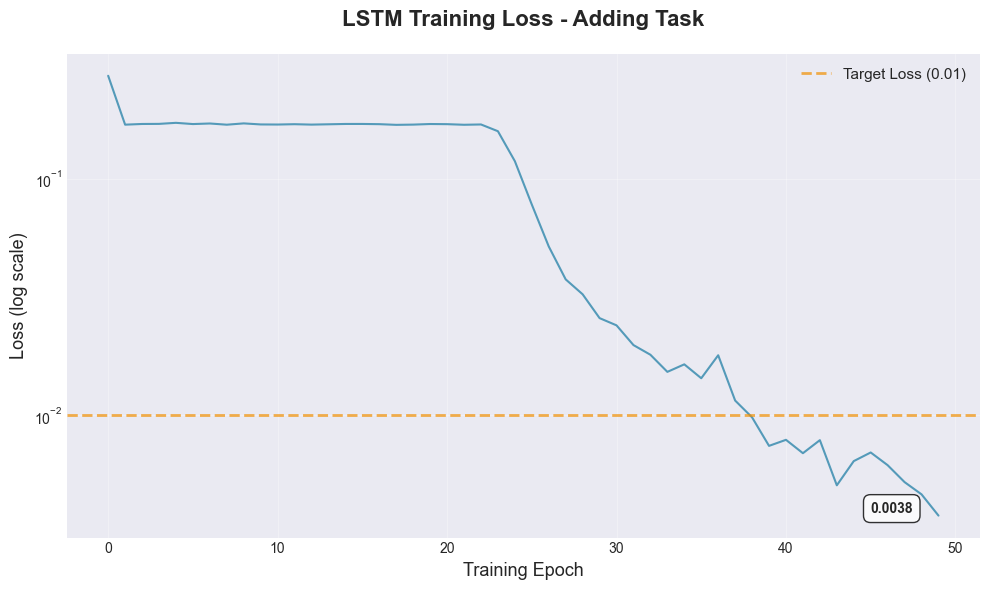

In [8]:
print(f"Total epochs: {len(losses)}")
print(f"Initial loss: {losses[0]:.6f}")
print(f"Final loss: {losses[-1]:.6f}")

plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# main plot
steps = np.arange(len(losses))
plt.semilogy(steps, np.array(losses), color='#2E86AB', linewidth=1.5, alpha=0.8)

# target line for a decent performance
plt.axhline(y=0.01, color='#F18F01', linestyle='--', linewidth=2, 
            label='Target Loss (0.01)', alpha=0.7)

# annotations
plt.text(len(losses)*0.95, losses[-1], f'{losses[-1]:.4f}', 
         ha='right', va='bottom', fontsize=10, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# title and legend
plt.title("LSTM Training Loss - Adding Task", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Training Epoch", fontsize=13)
plt.ylabel("Loss (log scale)", fontsize=13)
plt.legend(loc='upper right', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# save
plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

The curve looks good, reaching a value of around 
Finally, we can evaluate the model on the test set, to assess the generalization capabilities

In [9]:
@eqx.filter_jit

def eval_step(model:RNN, x, y):
    # define a loss function
    y_pred, hidden_states = eqx.filter_vmap(model)(x)
    return jax.numpy.sum(optax.l2_loss(y_pred, y[:, None]))

def evaluate_model(model, dataloader):
    loss_sum = 0
    n_seen = 0
    for x, y in dataloader:
        x = x.numpy()
        y = y.numpy()
        loss_sum += eval_step(model, x, y)
        n_seen += len(x)
    print(f"Final MSE: {(loss_sum / n_seen):.6f}")

evaluate_model(model, test_loader)


Final MSE: 0.001607


Pretty good! Surely, with more training and better hyperparameters, we could reach a lower loss, but the network is correctly fitted. 